#Instalar librerias

In [1]:
import tensorflow as tf
# Forzar uso de CPU para instalaciones
tf.config.set_visible_devices([], 'GPU')

print("Instalando librerías...")
!pip install -q tensorflow==2.19.0
!pip install -q seaborn
!pip install -q opencv-python
!pip install -q kagglehub
!pip install -q scipy
!pip install -q scikit-image

# Limpiar memoria inmediatamente después de instalaciones
import gc
gc.collect()
print("✅ Librerías instaladas y memoria limpiada")


Instalando librerías...
✅ Librerías instaladas y memoria limpiada


# IMportar

In [2]:
print("Importando librerías...")

# Configurar TensorFlow para uso eficiente de memoria
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import kagglehub
import zipfile
import shutil

print("✅ Librerías importadas correctamente")

Importando librerías...
✅ Librerías importadas correctamente


# Descargar dataset

In [3]:
print("Iniciando descarga del dataset...")

with tf.device('/CPU:0'):
    try:
        dataset_path = kagglehub.dataset_download("tpapp157/earth-terrain-height-and-segmentation-map-images")
        print(f"✅ Dataset descargado en: {dataset_path}")
    except Exception as e:
        print(f"❌ Error descargando dataset: {e}")
        # Usar dataset de respaldo si falla
        dataset_path = "/content/sample_data"

# Crear carpetas para organizar datos
terrain_dir = "/content/terrain_images"
height_dir = "/content/height_maps"
flood_mask_dir = "/content/flood_masks"

os.makedirs(terrain_dir, exist_ok=True)
os.makedirs(height_dir, exist_ok=True)
os.makedirs(flood_mask_dir, exist_ok=True)

# Verificar y organizar archivos
data_dir = os.path.join(dataset_path, "_dataset")
if not os.path.exists(data_dir):
    data_dir = dataset_path

print("Organizando archivos del dataset...")
files_processed = 0

for root, dirs, files in os.walk(data_dir):
    for f in files:
        if files_processed >= 5000:  # Límite para evitar memoria
            break
        f_lower = f.lower()
        src = os.path.join(root, f)

        try:
            if f_lower.endswith("_t.png"):
                shutil.copy(src, terrain_dir)
                files_processed += 1
            elif f_lower.endswith("_h.png"):
                shutil.copy(src, height_dir)
            elif f_lower.endswith("_i2.png"):
                shutil.copy(src, flood_mask_dir)
        except Exception as e:
            continue

print(f"✅ Dataset organizado:")
print(f"   - Terrain images: {len(os.listdir(terrain_dir))}")
print(f"   - Height maps: {len(os.listdir(height_dir))}")
print(f"   - Flood masks: {len(os.listdir(flood_mask_dir))}")

# Limpiar memoria
del dataset_path, data_dir
gc.collect()

Iniciando descarga del dataset...


100%|██████████| 3.75G/3.75G [00:47<00:00, 85.6MB/s]

Extracting files...


✅ Dataset descargado en: /root/.cache/kagglehub/datasets/tpapp157/earth-terrain-height-and-segmentation-map-images/versions/2
Organizando archivos del dataset...
✅ Dataset organizado:
   - Terrain images: 5000
   - Height maps: 4999
   - Flood masks: 4998


0

# Dataset optimizado

In [4]:
class OptimizedTerrainDataset:
    def __init__(self, terrain_dir, height_dir, flood_mask_dir, img_size=(128, 128), max_samples=3000,
                 water_rgb=(17, 141, 215), water_tol=25):
        self.terrain_dir = terrain_dir
        self.height_dir = height_dir
        self.flood_mask_dir = flood_mask_dir
        self.img_size = img_size
        self.max_samples = max_samples
        self.water_rgb = np.array(water_rgb, dtype=np.int16)
        self.water_tol = water_tol  # tolerancia para variaciones

    def load_images_and_masks(self):
        terrain_files = sorted(os.listdir(self.terrain_dir))[:self.max_samples]
        X = []
        y = []
        print(f"Cargando {len(terrain_files)} imágenes con tamaño {self.img_size}...")
        for fname in tqdm(terrain_files, desc="Procesando imágenes"):
            try:
                base_name = fname.replace("_t.png", "")
                terrain_path = os.path.join(self.terrain_dir, fname)
                height_path = os.path.join(self.height_dir, f"{base_name}_h.png")
                seg_path = os.path.join(self.flood_mask_dir, f"{base_name}_i2.png")
                if not (os.path.exists(height_path) and os.path.exists(seg_path)):
                    continue

                with tf.device('/CPU:0'):
                    # Terreno RGB
                    terrain_img = Image.open(terrain_path).convert('RGB').resize(self.img_size)
                    terrain_array = np.array(terrain_img, dtype=np.float32) / 255.0

                    # Altura
                    height_img = Image.open(height_path)
                    height_resized = height_img.resize(self.img_size, Image.NEAREST)
                    height_array = np.array(height_resized, dtype=np.float32)
                    height_norm = height_array / height_array.max() if height_array.max() > 0 else height_array
                    height_norm = np.expand_dims(height_norm, axis=-1)

                    # Canales
                    img_with_height = np.concatenate([terrain_array, height_norm], axis=-1)

                    # Máscara corregida
                    mask = self.create_simple_mask(seg_path, height_array)

                    X.append(img_with_height)
                    y.append(mask)

            except Exception as e:
                print(f"Error procesando {fname}: {e}")
                continue
            if len(X) and len(X) % 500 == 0:
                gc.collect()

        print(f"✅ Procesadas {len(X)} imágenes válidas")
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.uint8)

    def create_simple_mask(self, seg_path, height_array):
        seg_rgb = np.array(Image.open(seg_path).convert('RGB').resize(self.img_size, Image.NEAREST), dtype=np.int16)

        diff = np.abs(seg_rgb - self.water_rgb)
        water_mask = (diff[..., 0] <= self.water_tol) & (diff[..., 1] <= self.water_tol) & (diff[..., 2] <= self.water_tol)

        mask = np.zeros(seg_rgb.shape[:2], dtype=np.uint8)
        mask[water_mask] = 1  # Clase 1 = Agua / Inundación

        low_thresh = np.percentile(height_array[~water_mask], 25) if np.any(~water_mask) else np.percentile(height_array, 25)
        depression_mask = (height_array < low_thresh) & (~water_mask)
        mask[depression_mask] = 2  # Clase 2 = Depresión en tierra

        return mask

# Cargar datos por lotes

In [5]:
print("Iniciando carga de datos...")

with tf.device('/CPU:0'):
    dataset = OptimizedTerrainDataset(terrain_dir, height_dir, flood_mask_dir,
                                    img_size=(128, 128), max_samples=3000)
    X, y = dataset.load_images_and_masks()

print(f"Shapes finales: X {X.shape}, y {y.shape}")

# One-hot encoding
num_classes = 3
y_cat = to_categorical(y, num_classes)

# Dividir datos
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42 # Removed stratify
)

# Liberar memoria de arrays temporales
del X, y, y_cat
gc.collect()

print(f"✅ Datos preparados:")
print(f"   - Train: {X_train.shape}, {y_train.shape}")
print(f"   - Validation: {X_val.shape}, {y_val.shape}")

# Verificar distribución de clases (optional, can be removed if not needed without stratification)
# unique, counts = np.unique(np.argmax(y_train, axis=-1), return_counts=True)
# print("Distribución de clases en TRAIN:", dict(zip(unique, counts)))

Iniciando carga de datos...
Cargando 3000 imágenes con tamaño (128, 128)...


Procesando imágenes: 100%|██████████| 3000/3000 [01:13<00:00, 40.94it/s]


✅ Procesadas 2999 imágenes válidas
Shapes finales: X (2999, 128, 128, 4), y (2999, 128, 128)
✅ Datos preparados:
   - Train: (2399, 128, 128, 4), (2399, 128, 128, 3)
   - Validation: (600, 128, 128, 4), (600, 128, 128, 3)


# Modelo ViT-UNet

In [6]:
def create_vit_unet_model(input_shape=(128, 128, 4), num_classes=3,
                          patch_size=8, embed_dim=64, num_heads=4,
                          mlp_dim=128, depth=6, dropout=0.1):
    import tensorflow as tf
    from tensorflow.keras import layers, models

    H, W, C = input_shape
    assert H % patch_size == 0 and W % patch_size == 0, "H y W deben ser múltiplos de patch_size"
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    num_patches = num_patches_h * num_patches_w

    def transformer_block(x):
        # Atajo
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        x1 = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=embed_dim // num_heads,
                                       dropout=dropout)(x1, x1)
        x1 = layers.Dropout(dropout)(x1)
        x = layers.Add()([x, x1])

        x2 = layers.LayerNormalization(epsilon=1e-6)(x)
        x2 = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x2)
        x2 = layers.Dropout(dropout)(x2)
        x2 = layers.Dense(embed_dim)(x2)
        x2 = layers.Dropout(dropout)(x2)
        x = layers.Add()([x, x2])
        return x

    inputs = layers.Input(shape=input_shape)

    # Patch embedding con conv (conv con kernel=stride=patch_size)
    x = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size,
                      padding='valid', use_bias=False)(inputs)  # (H/P, W/P, E)
    # A tokens (N, E)
    x = layers.Reshape((num_patches, embed_dim))(x)

    # Positional embeddings aprendibles
    pos_emb = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    x = x + pos_emb(positions)

    # Encoder Transformer
    for _ in range(depth):
        x = transformer_block(x)

    # Volver a grid (H/P, W/P, E)
    x = layers.Reshape((num_patches_h, num_patches_w, embed_dim))(x)

    # Decoder ligero (Upsampling conv)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(dropout)(x)

    x = layers.UpSampling2D(size=2, interpolation='bilinear')(x)  # 16->32
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=2, interpolation='bilinear')(x)  # 32->64
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=2, interpolation='bilinear')(x)  # 64->128
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(x)

    return models.Model(inputs, outputs, name="vit_unet_lite")


# Focal Losss

In [7]:
def focal_loss(gamma=2., alpha=None):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        if alpha is not None:
            weights = alpha * tf.pow(1 - y_pred, gamma)
        else:
            weights = tf.pow(1 - y_pred, gamma)
        loss = weights * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss

# Compilar modelo

In [8]:
print("Compilando modelo...")

strategy = tf.distribute.MirroredStrategy() if len(tf.config.list_physical_devices('GPU')) > 1 else tf.distribute.get_strategy()

with strategy.scope():
    # Reemplazar U-Net por ViT-UNet
    model = create_vit_unet_model(input_shape=(128, 128, 4), num_classes=3,
                                  patch_size=8, embed_dim=64, num_heads=4,
                                  mlp_dim=128, depth=6, dropout=0.1)

    alpha = tf.constant([1.0, 1.5, 2.0])
    loss_fn = focal_loss(gamma=2.0, alpha=alpha)

    model.compile(
        optimizer=Adam(1e-4),
        loss=loss_fn,
        metrics=['accuracy']
    )

model.summary()

Compilando modelo...


Model: "vit_unet_lite"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │     16,384 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256, 64)   │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 64)   │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 64)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 128)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 64)   │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256, 64)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 64)   │          0 │ add_1[0][0],      │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 64)   │          0 │ add_2[0][0],      │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 388,003 (1.48 MB)

 Trainable params: 388,003 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento

In [9]:
print("Iniciando entrenamiento...")

# Callbacks para evitar overfitting y gestionar memoria
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=4,
        factor=0.5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False
    )
]

# Entrenar con batch size pequeño
try:
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,  # Menos épocas
        batch_size=4,  # Batch pequeño para memoria
        callbacks=callbacks,
        verbose=1
    )

    print("✅ Entrenamiento completado exitosamente")

except Exception as e:
    print(f"❌ Error durante entrenamiento: {e}")
    print("Intentando con configuración más liviana...")

    # Configuración de emergencia si falla la memoria
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=2,
        callbacks=callbacks,
        verbose=1
    )

# Liberar memoria de datos de entrenamiento
del X_train, y_train, X_val, y_val
gc.collect()


Iniciando entrenamiento...
Epoch 1/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7554 - loss: 0.3203

600/600 ━━━━━━━━━━━━━━━━━━━━ 376s 586ms/step - accuracy: 0.7556 - loss: 0.3201 - val_accuracy: 0.8883 - val_loss: 0.1316 - learning_rate: 1.0000e-04
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8876 - loss: 0.1302

600/600 ━━━━━━━━━━━━━━━━━━━━ 378s 580ms/step - accuracy: 0.8876 - loss: 0.1302 - val_accuracy: 0.9030 - val_loss: 0.1125 - learning_rate: 1.0000e-04
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9008 - loss: 0.1149

600/600 ━━━━━━━━━━━━━━━━━━━━ 410s 625ms/step - accuracy: 0.9008 - loss: 0.1149 - val_accuracy: 0.9142 - val_loss: 0.1060 - learning_rate: 1.0000e-04
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9057 - loss: 0.1088

600/600 ━━━━━━━━━━━━━━━━━━━━ 348s 580ms/step - accuracy: 0.9057 - loss: 0.1088 - val_accuracy: 0.9156 - val_loss: 0.1057 - learning_rate: 1.0000e-04
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9090 - loss: 0.1019

600/600 ━━━━━━━━━━━━━━━━━━━━ 340s 567ms/step - accuracy: 0.9090 - loss: 0.1019 - val_accuracy: 0.9159 - val_loss: 0.0956 - learning_rate: 1.0000e-04
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9105 - loss: 0.1010

600/600 ━━━━━━━━━━━━━━━━━━━━ 356s 594ms/step - accuracy: 0.9105 - loss: 0.1010 - val_accuracy: 0.9202 - val_loss: 0.0916 - learning_rate: 1.0000e-04
Epoch 7/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 363s 605ms/step - accuracy: 0.9137 - loss: 0.0953 - val_accuracy: 0.9220 - val_loss: 0.0935 - learning_rate: 1.0000e-04
Epoch 8/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9128 - loss: 0.0944

600/600 ━━━━━━━━━━━━━━━━━━━━ 361s 571ms/step - accuracy: 0.9128 - loss: 0.0944 - val_accuracy: 0.9228 - val_loss: 0.0887 - learning_rate: 1.0000e-04
Epoch 9/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9151 - loss: 0.0904

600/600 ━━━━━━━━━━━━━━━━━━━━ 357s 596ms/step - accuracy: 0.9151 - loss: 0.0904 - val_accuracy: 0.9254 - val_loss: 0.0853 - learning_rate: 1.0000e-04
Epoch 10/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9177 - loss: 0.0877

600/600 ━━━━━━━━━━━━━━━━━━━━ 368s 614ms/step - accuracy: 0.9177 - loss: 0.0877 - val_accuracy: 0.9236 - val_loss: 0.0829 - learning_rate: 1.0000e-04
Epoch 11/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9192 - loss: 0.0849

600/600 ━━━━━━━━━━━━━━━━━━━━ 342s 571ms/step - accuracy: 0.9192 - loss: 0.0849 - val_accuracy: 0.9272 - val_loss: 0.0790 - learning_rate: 1.0000e-04
Epoch 12/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 342s 570ms/step - accuracy: 0.9170 - loss: 0.0863 - val_accuracy: 0.9260 - val_loss: 0.0798 - learning_rate: 1.0000e-04
Epoch 13/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9229 - loss: 0.0806

600/600 ━━━━━━━━━━━━━━━━━━━━ 346s 577ms/step - accuracy: 0.9229 - loss: 0.0806 - val_accuracy: 0.9292 - val_loss: 0.0760 - learning_rate: 1.0000e-04
Epoch 14/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9233 - loss: 0.0787

600/600 ━━━━━━━━━━━━━━━━━━━━ 378s 571ms/step - accuracy: 0.9233 - loss: 0.0787 - val_accuracy: 0.9292 - val_loss: 0.0738 - learning_rate: 1.0000e-04
Epoch 15/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9245 - loss: 0.0781

600/600 ━━━━━━━━━━━━━━━━━━━━ 359s 598ms/step - accuracy: 0.9245 - loss: 0.0781 - val_accuracy: 0.9298 - val_loss: 0.0726 - learning_rate: 1.0000e-04
Epoch 16/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 345s 574ms/step - accuracy: 0.9241 - loss: 0.0772 - val_accuracy: 0.9333 - val_loss: 0.0727 - learning_rate: 1.0000e-04
Epoch 17/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9259 - loss: 0.0753

600/600 ━━━━━━━━━━━━━━━━━━━━ 380s 572ms/step - accuracy: 0.9259 - loss: 0.0753 - val_accuracy: 0.9322 - val_loss: 0.0713 - learning_rate: 1.0000e-04
Epoch 18/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9256 - loss: 0.0750

600/600 ━━━━━━━━━━━━━━━━━━━━ 340s 567ms/step - accuracy: 0.9256 - loss: 0.0750 - val_accuracy: 0.9310 - val_loss: 0.0700 - learning_rate: 1.0000e-04
Epoch 19/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9270 - loss: 0.0737

600/600 ━━━━━━━━━━━━━━━━━━━━ 348s 581ms/step - accuracy: 0.9270 - loss: 0.0737 - val_accuracy: 0.9275 - val_loss: 0.0693 - learning_rate: 1.0000e-04
Epoch 20/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 360s 600ms/step - accuracy: 0.9265 - loss: 0.0738 - val_accuracy: 0.9343 - val_loss: 0.0694 - learning_rate: 1.0000e-04
Epoch 21/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9290 - loss: 0.0711

600/600 ━━━━━━━━━━━━━━━━━━━━ 346s 577ms/step - accuracy: 0.9290 - loss: 0.0711 - val_accuracy: 0.9330 - val_loss: 0.0686 - learning_rate: 1.0000e-04
Epoch 22/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 397s 601ms/step - accuracy: 0.9292 - loss: 0.0710 - val_accuracy: 0.9267 - val_loss: 0.0688 - learning_rate: 1.0000e-04
Epoch 23/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 342s 570ms/step - accuracy: 0.9295 - loss: 0.0702 - val_accuracy: 0.9357 - val_loss: 0.0688 - learning_rate: 1.0000e-04
Epoch 24/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9297 - loss: 0.0695

600/600 ━━━━━━━━━━━━━━━━━━━━ 345s 574ms/step - accuracy: 0.9297 - loss: 0.0695 - val_accuracy: 0.9329 - val_loss: 0.0667 - learning_rate: 1.0000e-04
Epoch 25/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9309 - loss: 0.0687

600/600 ━━━━━━━━━━━━━━━━━━━━ 401s 606ms/step - accuracy: 0.9309 - loss: 0.0687 - val_accuracy: 0.9336 - val_loss: 0.0665 - learning_rate: 1.0000e-04
Epoch 26/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9306 - loss: 0.0690

600/600 ━━━━━━━━━━━━━━━━━━━━ 345s 575ms/step - accuracy: 0.9306 - loss: 0.0690 - val_accuracy: 0.9346 - val_loss: 0.0661 - learning_rate: 1.0000e-04
Epoch 27/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9307 - loss: 0.0686

600/600 ━━━━━━━━━━━━━━━━━━━━ 346s 577ms/step - accuracy: 0.9307 - loss: 0.0686 - val_accuracy: 0.9358 - val_loss: 0.0655 - learning_rate: 1.0000e-04
Epoch 28/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9308 - loss: 0.0686

600/600 ━━━━━━━━━━━━━━━━━━━━ 348s 579ms/step - accuracy: 0.9308 - loss: 0.0686 - val_accuracy: 0.9344 - val_loss: 0.0654 - learning_rate: 1.0000e-04
Epoch 29/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9312 - loss: 0.0674

600/600 ━━━━━━━━━━━━━━━━━━━━ 383s 581ms/step - accuracy: 0.9312 - loss: 0.0674 - val_accuracy: 0.9362 - val_loss: 0.0652 - learning_rate: 1.0000e-04
Epoch 30/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 379s 575ms/step - accuracy: 0.9308 - loss: 0.0676 - val_accuracy: 0.9373 - val_loss: 0.0655 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 29.
✅ Entrenamiento completado exitosamente


6561

# Evaluación y visualización

Cargando mejores pesos para evaluación...
Cargando 100 imágenes con tamaño (128, 128)...


Procesando imágenes: 100%|██████████| 100/100 [00:02<00:00, 37.07it/s]


✅ Procesadas 100 imágenes válidas
Evaluando modelo...
✅ Evaluación final - Loss: 0.0651, Accuracy: 0.9361
Generando visualizaciones...


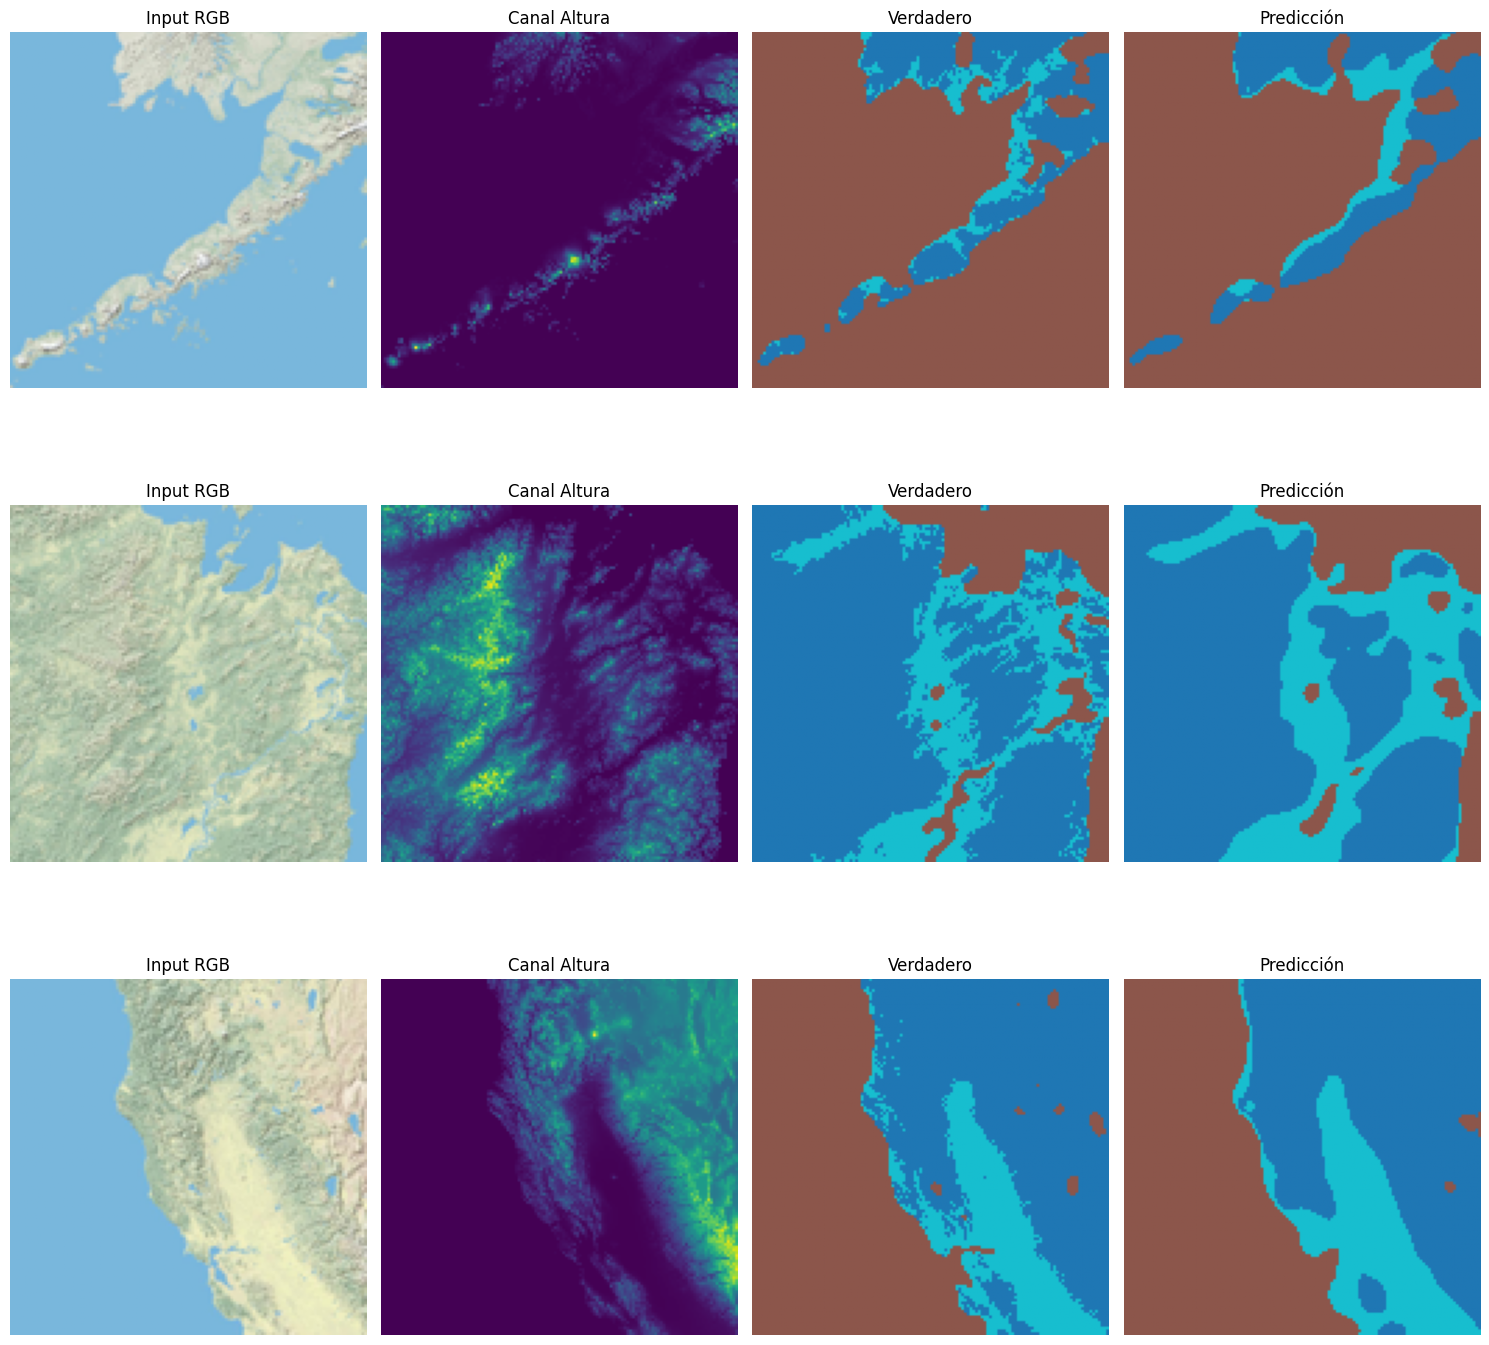

27372

In [10]:
print("Cargando mejores pesos para evaluación...")
model.load_weights('best_model.h5')

# Cargar un pequeño subset para evaluación
with tf.device('/CPU:0'):
    dataset_eval = OptimizedTerrainDataset(terrain_dir, height_dir, flood_mask_dir,
                                         img_size=(128, 128), max_samples=100)
    X_eval, y_eval = dataset_eval.load_images_and_masks()
    y_eval_cat = to_categorical(y_eval, num_classes)

print("Evaluando modelo...")
val_loss, val_acc = model.evaluate(X_eval, y_eval_cat, verbose=0)
print(f"✅ Evaluación final - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# Visualizar algunas predicciones
print("Generando visualizaciones...")
import matplotlib.pyplot as plt

def visualize_predictions(model, X, y_true, num_samples=3):
    indices = np.random.choice(len(X), num_samples, replace=False)

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        # Predicción
        pred = model.predict(X[idx:idx+1], verbose=0)
        pred_mask = np.argmax(pred[0], axis=-1)
        true_mask = np.argmax(y_true[idx], axis=-1)

        # Visualizar
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(X[idx][..., :3])
        plt.title("Input RGB")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(X[idx][..., 3], cmap='viridis')
        plt.title("Canal Altura")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(true_mask, cmap='tab10')
        plt.title("Verdadero")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(pred_mask, cmap='tab10')
        plt.title("Predicción")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar algunas predicciones
visualize_predictions(model, X_eval, y_eval_cat, num_samples=3)

# Liberar memoria
del X_eval, y_eval, y_eval_cat
gc.collect()


In [11]:
# The code from this cell has been moved to the previous cell (ZzhKCa5EsKmp) to resolve the NameError.

# Guardar modelos

In [12]:

print("Guardando modelos y resultados...")

# Guardar modelo completo
model.save("terrain_segmentation_model_final.h5")
print("✅ Modelo completo guardado")

# Guardar arquitectura
model_json = model.to_json()
with open("terrain_segmentation_model.json", "w") as json_file:
    json_file.write(model_json)
print("✅ Arquitectura del modelo guardada")

# Guardar historial de entrenamiento
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.to_csv("training_history.csv", index=False)
print("✅ Historial de entrenamiento guardado")


Guardando modelos y resultados...
✅ Modelo completo guardado
✅ Arquitectura del modelo guardada
✅ Historial de entrenamiento guardado


# Conversión a tensorflow

In [13]:
print("Convirtiendo a TensorFlow Lite...")

try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    with open("terrain_segmentation_model.tflite", "wb") as f:
        f.write(tflite_model)
    print("✅ Modelo TensorFlow Lite guardado")

except Exception as e:
    print(f"❌ Error en conversión TFLite: {e}")


Convirtiendo a TensorFlow Lite...
Saved artifact at '/tmp/tmpwt3o21uy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Captures:
  140098252466384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140098252466768: TensorSpec(shape=(256, 64), dtype=tf.float32, name=None)
  140098250722768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140098252464080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140098252468688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140098252467344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140098252469072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140098252468304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140098252466960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140098252469648: TensorSpec(shape=

# Descargar archivos

In [14]:
print("Preparando archivos para descarga...")

files_to_download = [
    "terrain_segmentation_model_final.h5",
    "terrain_segmentation_model.json",
    "training_history.csv",
    "terrain_segmentation_model.tflite"
]

from google.colab import files

for file_name in files_to_download:
    if os.path.exists(file_name):
        files.download(file_name)
        print(f"✅ {file_name} descargado")
    else:
        print(f"⚠️ {file_name} no encontrado")

print("🎯 ¡Proceso completado exitosamente!")

Preparando archivos para descarga...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ terrain_segmentation_model_final.h5 descargado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ terrain_segmentation_model.json descargado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ training_history.csv descargado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ terrain_segmentation_model.tflite descargado
🎯 ¡Proceso completado exitosamente!


# Evaluación completa

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from tqdm import tqdm
import gc


In [16]:
print("📥 Cargando modelo y datos de evaluación...")

# Cargar el modelo guardado
try:
    # Recreate the alpha tensor used during compilation
    alpha_for_loading = tf.constant([1.0, 1.5, 2.0])
    # Recreate the exact callable loss function used during compilation
    custom_loss_for_loading = focal_loss(gamma=2.0, alpha=alpha_for_loading)

    model = tf.keras.models.load_model("terrain_segmentation_model_final.h5",
                                      custom_objects={'loss': custom_loss_for_loading})
    print("✅ Modelo cargado correctamente")
except Exception as e:
    print(f"❌ Error al cargar modelo: {e}")
    print("⚠️  Usando modelo en memoria (si existía previamente o falló la carga)")

# Cargar conjunto de evaluación más grande
with tf.device('/CPU:0'):
    dataset_eval = OptimizedTerrainDataset(terrain_dir, height_dir, flood_mask_dir,
                                         img_size=(128, 128), max_samples=500)
    X_test, y_test = dataset_eval.load_images_and_masks()
    y_test_cat = to_categorical(y_test, num_classes=3)

print(f"📊 Conjunto de evaluación: {X_test.shape}, {y_test.shape}")

📥 Cargando modelo y datos de evaluación...
❌ Error al cargar modelo: too many positional arguments
⚠️  Usando modelo en memoria (si existía previamente o falló la carga)
Cargando 500 imágenes con tamaño (128, 128)...


Procesando imágenes: 100%|██████████| 500/500 [00:14<00:00, 35.29it/s]


✅ Procesadas 500 imágenes válidas
📊 Conjunto de evaluación: (500, 128, 128, 4), (500, 128, 128)


# Evaluación cuantitativa

In [17]:
print("\n📈 EVALUACIÓN CUANTITATIVA")
print("-" * 30)

# Evaluación estándar
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"📊 Precisión general: {test_accuracy:.4f}")
print(f"📊 Pérdida general: {test_loss:.4f}")

# Predicciones
print("🎯 Generando predicciones...")
y_pred_probs = model.predict(X_test, verbose=0, batch_size=4)
y_pred = np.argmax(y_pred_probs, axis=-1)
y_true = y_test

# Aplanar para métricas por píxel
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()


📈 EVALUACIÓN CUANTITATIVA
------------------------------
📊 Precisión general: 0.9382
📊 Pérdida general: 0.0628
🎯 Generando predicciones...


# Metricas por clase

In [18]:
print("\n🎯 MÉTRICAS POR CLASE")
print("-" * 30)

class_names = ['Normal', 'Inundación', 'Depresión']
report = classification_report(y_true_flat, y_pred_flat,
                              target_names=class_names, digits=4)
print("Classification Report:")
print(report)

# Métricas adicionales por clase
precision, recall, fscore, support = precision_recall_fscore_support(
    y_true_flat, y_pred_flat, average=None, labels=[0, 1, 2]
)

print("\n📊 Resumen por clase:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:10} - Precisión: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {fscore[i]:.4f}, Soporte: {support[i]}")



🎯 MÉTRICAS POR CLASE
------------------------------
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9548    0.9364    0.9455   4189219
  Inundación     0.9856    0.9806    0.9831   2607542
   Depresión     0.8096    0.8641    0.8360   1395239

    accuracy                         0.9382   8192000
   macro avg     0.9167    0.9270    0.9215   8192000
weighted avg     0.9399    0.9382    0.9388   8192000


📊 Resumen por clase:
  Normal     - Precisión: 0.9548, Recall: 0.9364, F1: 0.9455, Soporte: 4189219
  Inundación - Precisión: 0.9856, Recall: 0.9806, F1: 0.9831, Soporte: 2607542
  Depresión  - Precisión: 0.8096, Recall: 0.8641, F1: 0.8360, Soporte: 1395239


# Matriz de confusión


📊 MATRIZ DE CONFUSIÓN
------------------------------


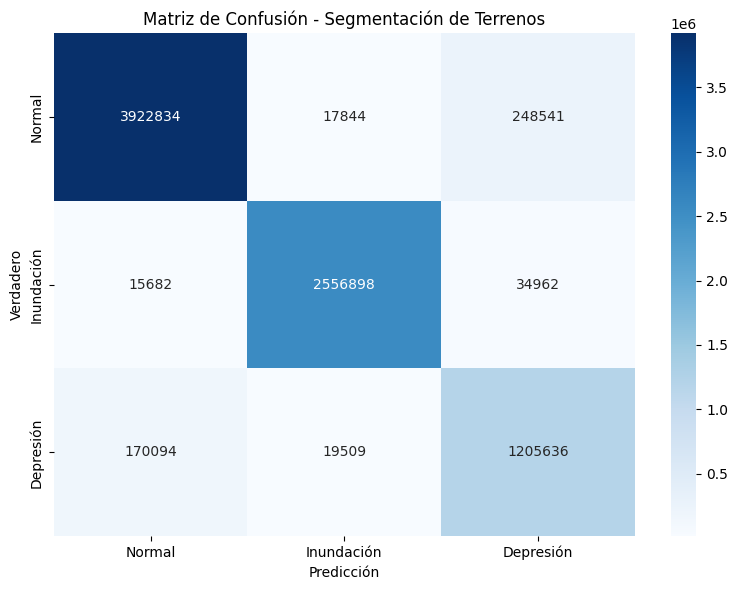

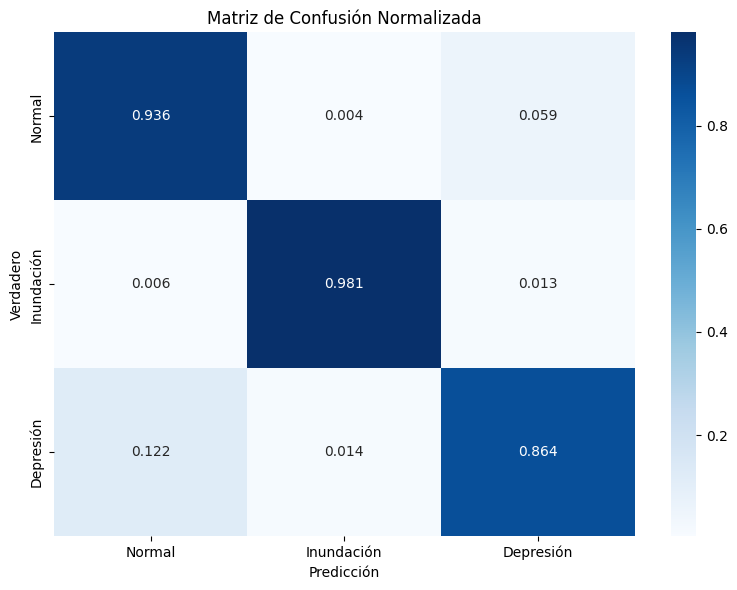

In [19]:
print("\n📊 MATRIZ DE CONFUSIÓN")
print("-" * 30)

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Segmentación de Terrenos')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

# Matriz normalizada
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión Normalizada')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()


# ANÁLISIS DE DISTRIBUCIÓN DE CLASES

In [20]:
print("\n📈 DISTRIBUCIÓN DE CLASES")
print("-" * 30)

unique_true, counts_true = np.unique(y_true_flat, return_counts=True)
unique_pred, counts_pred = np.unique(y_pred_flat, return_counts=True)

print("Distribución real:")
for class_idx, count in zip(unique_true, counts_true):
    percentage = (count / len(y_true_flat)) * 100
    print(f"  {class_names[class_idx]:10}: {count:8d} píxeles ({percentage:6.2f}%)")

print("\nDistribución predicha:")
for class_idx, count in zip(unique_pred, counts_pred):
    percentage = (count / len(y_pred_flat)) * 100
    print(f"  {class_names[class_idx]:10}: {count:8d} píxeles ({percentage:6.2f}%)")


📈 DISTRIBUCIÓN DE CLASES
------------------------------
Distribución real:
  Normal    :  4189219 píxeles ( 51.14%)
  Inundación:  2607542 píxeles ( 31.83%)
  Depresión :  1395239 píxeles ( 17.03%)

Distribución predicha:
  Normal    :  4108610 píxeles ( 50.15%)
  Inundación:  2594251 píxeles ( 31.67%)
  Depresión :  1489139 píxeles ( 18.18%)


# Visualización de predicciones


🎨 VISUALIZACIÓN DETALLADA DE PREDICCIONES
----------------------------------------


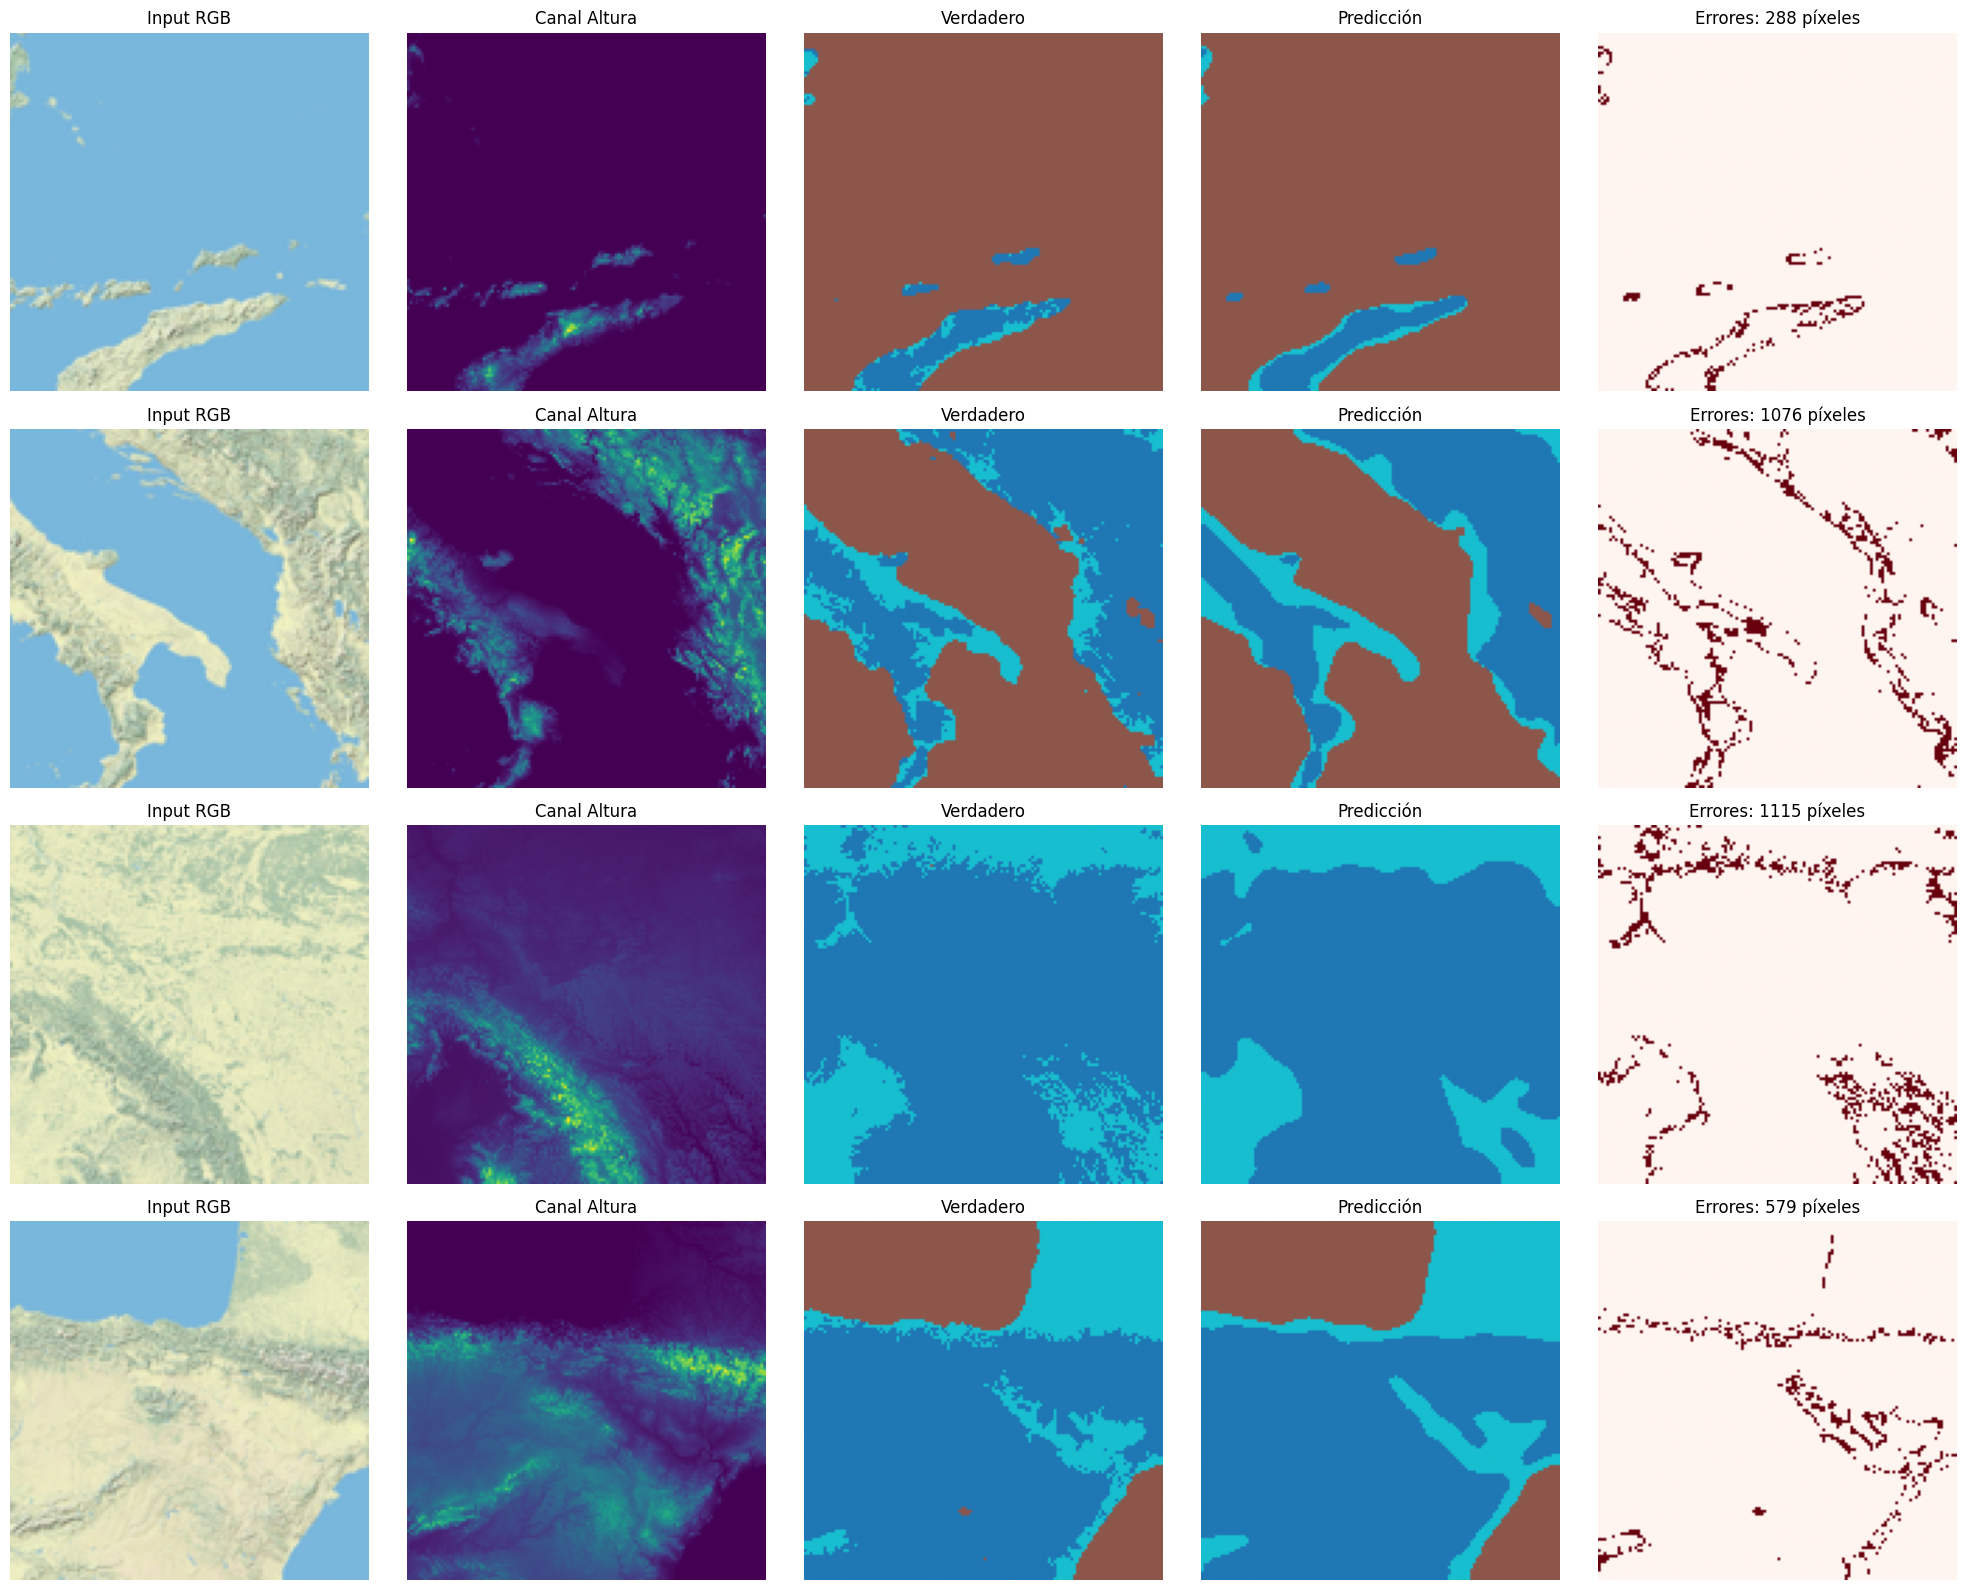

In [21]:
print("\n🎨 VISUALIZACIÓN DETALLADA DE PREDICCIONES")
print("-" * 40)

def visualize_detailed_predictions(model, X, y_true, num_samples=5):
    indices = np.random.choice(len(X), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4 * num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Predicción
        pred = model.predict(X[idx:idx+1], verbose=0)
        pred_mask = np.argmax(pred[0], axis=-1)
        true_mask = y_true[idx]

        # RGB
        axes[i, 0].imshow(X[idx][..., :3])
        axes[i, 0].set_title("Input RGB")
        axes[i, 0].axis('off')

        # Canal de altura
        axes[i, 1].imshow(X[idx][..., 3], cmap='viridis')
        axes[i, 1].set_title("Canal Altura")
        axes[i, 1].axis('off')

        # Verdadero
        axes[i, 2].imshow(true_mask, cmap='tab10', vmin=0, vmax=2)
        axes[i, 2].set_title("Verdadero")
        axes[i, 2].axis('off')

        # Predicción
        axes[i, 3].imshow(pred_mask, cmap='tab10', vmin=0, vmax=2)
        axes[i, 3].set_title("Predicción")
        axes[i, 3].axis('off')

        # Diferencia
        diff = np.where(true_mask != pred_mask, 1, 0)
        axes[i, 4].imshow(diff, cmap='Reds')
        axes[i, 4].set_title(f"Errores: {diff.sum()} píxeles")
        axes[i, 4].axis('off')

    plt.tight_layout()
    plt.show()

    return indices

# Visualizar predicciones detalladas
sample_indices = visualize_detailed_predictions(model, X_test, y_test, num_samples=4)

# Analisis de confianza de las predicciones


📊 ANÁLISIS DE CONFIANZA DE LAS PREDICCIONES
----------------------------------------
Confianza promedio: 0.8644 ± 0.1560


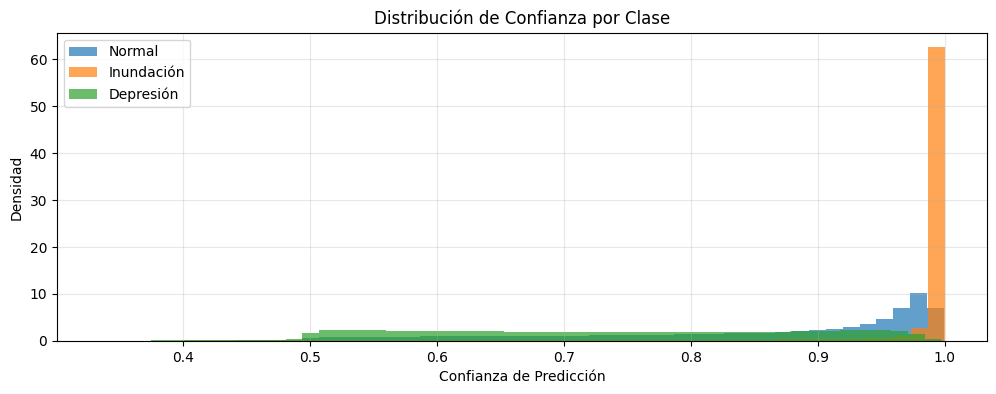

In [22]:
print("\n📊 ANÁLISIS DE CONFIANZA DE LAS PREDICCIONES")
print("-" * 40)

# Calcular confianza por clase
confidences = np.max(y_pred_probs, axis=-1)
mean_confidence = np.mean(confidences)
std_confidence = np.std(confidences)

print(f"Confianza promedio: {mean_confidence:.4f} ± {std_confidence:.4f}")

# Distribución de confianza por clase
plt.figure(figsize=(12, 4))

for class_idx in range(3):
    class_mask = (y_pred == class_idx)
    if np.any(class_mask):
        class_confidences = confidences[class_mask]
        plt.hist(class_confidences.flatten(), bins=50, alpha=0.7,
                label=f'{class_names[class_idx]}', density=True)

plt.xlabel('Confianza de Predicción')
plt.ylabel('Densidad')
plt.title('Distribución de Confianza por Clase')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Analisis de errors comunes

In [23]:
print("\n🔍 ANÁLISIS DE ERRORES COMUNES")
print("-" * 30)

# Encontrar los errores más frecuentes
error_mask = (y_true != y_pred)
error_count = np.sum(error_mask)

print(f"Total de píxeles con error: {error_count}")
print(f"Tasa de error global: {(error_count / len(y_true_flat)) * 100:.2f}%")

# Análisis de tipos de error
error_types = {}
for true_class in range(3):
    for pred_class in range(3):
        if true_class != pred_class:
            error_count = np.sum((y_true == true_class) & (y_pred == pred_class))
            if error_count > 0:
                error_types[(true_class, pred_class)] = error_count

print("\nTipos de error más frecuentes:")
for (true_class, pred_class), count in sorted(error_types.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {class_names[true_class]} → {class_names[pred_class]}: {count:6d} píxeles")


🔍 ANÁLISIS DE ERRORES COMUNES
------------------------------
Total de píxeles con error: 506632
Tasa de error global: 6.18%

Tipos de error más frecuentes:
  Normal → Depresión: 248541 píxeles
  Depresión → Normal: 170094 píxeles
  Inundación → Depresión:  34962 píxeles
  Depresión → Inundación:  19509 píxeles
  Normal → Inundación:  17844 píxeles
  Inundación → Normal:  15682 píxeles


# Evaluación de caracteristicas de imagen

In [24]:
print("\n🌄 EVALUACIÓN POR CARACTERÍSTICAS DE IMAGEN")
print("-" * 40)

# Analizar rendimiento por rango de alturas
height_values = X_test[..., 3].flatten()
height_bins = np.percentile(height_values, [0, 25, 50, 75, 100])

accuracies_by_height = []
for i in range(len(height_bins) - 1):
    mask = (height_values >= height_bins[i]) & (height_values < height_bins[i+1])
    if np.sum(mask) > 0:
        bin_accuracy = np.mean(y_true_flat[mask] == y_pred_flat[mask])
        accuracies_by_height.append(bin_accuracy)
        print(f"Altura [{height_bins[i]:.3f}-{height_bins[i+1]:.3f}]: {bin_accuracy:.4f} precisión")



🌄 EVALUACIÓN POR CARACTERÍSTICAS DE IMAGEN
----------------------------------------
Altura [0.000-0.000]: 0.9975 precisión
Altura [0.000-0.122]: 0.8920 precisión
Altura [0.122-0.325]: 0.9007 precisión
Altura [0.325-1.000]: 0.9624 precisión
